# **Thư viện**

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error



# **Dữ liệu**

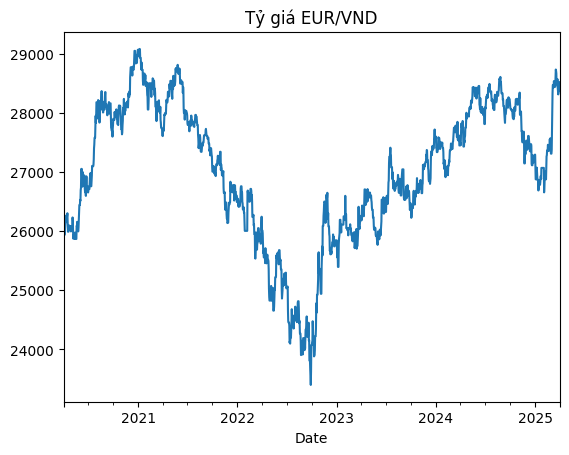

In [53]:
df = pd.read_csv(r"C:\Users\DELL\Downloads\eur-vnd-exchange-rate\data\processed\EUR_VND_Exchange_Rate.csv")
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')

y = df['Sell']
y.plot(title="Tỷ giá EUR/VND")
plt.show()

<Figure size 1400x1000 with 0 Axes>

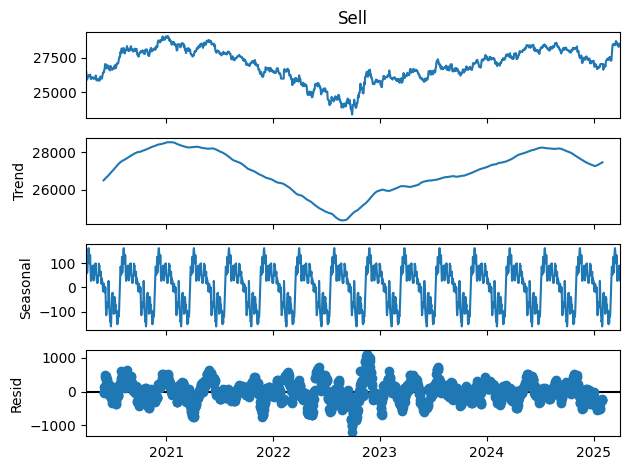

In [54]:
# Phân tích thành phần của chuỗi thời gian
decomposition = seasonal_decompose(df['Sell'], model='additive', period=120)
plt.figure(figsize=(14, 10))
decomposition.plot()
plt.tight_layout()
plt.show()

# **Kiểm tra tính dừng (ADF Test)**

In [55]:
result = adfuller(y)
print('ADF Statistic:', result[0])
print('p-value:', result[1])

if result[1] < 0.05:
    print("Chuỗi dừng")
else:
    print("Chuỗi không dừng, cần lấy sai phân")


ADF Statistic: -1.671871807232598
p-value: 0.445660109931818
Chuỗi không dừng, cần lấy sai phân


## **Lấy sai phân**

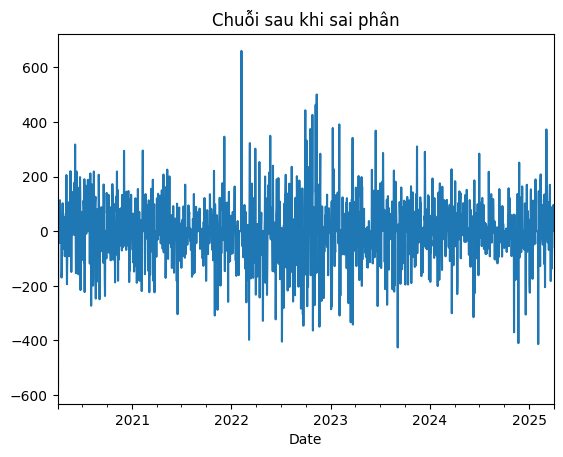

In [56]:
y_diff = y.diff().dropna()
y_diff.plot(title="Chuỗi sau khi sai phân")
plt.show()

In [57]:
result = adfuller(y_diff)
print('ADF Statistic:', result[0])
print('p-value:', result[1])

if result[1] < 0.05:
    print("Chuỗi dừng")
else:
    print("Chuỗi không dừng, cần lấy sai phân")

ADF Statistic: -41.730831684529434
p-value: 0.0
Chuỗi dừng


=> d = 1

# **ACF và PACF để chọn p, q**

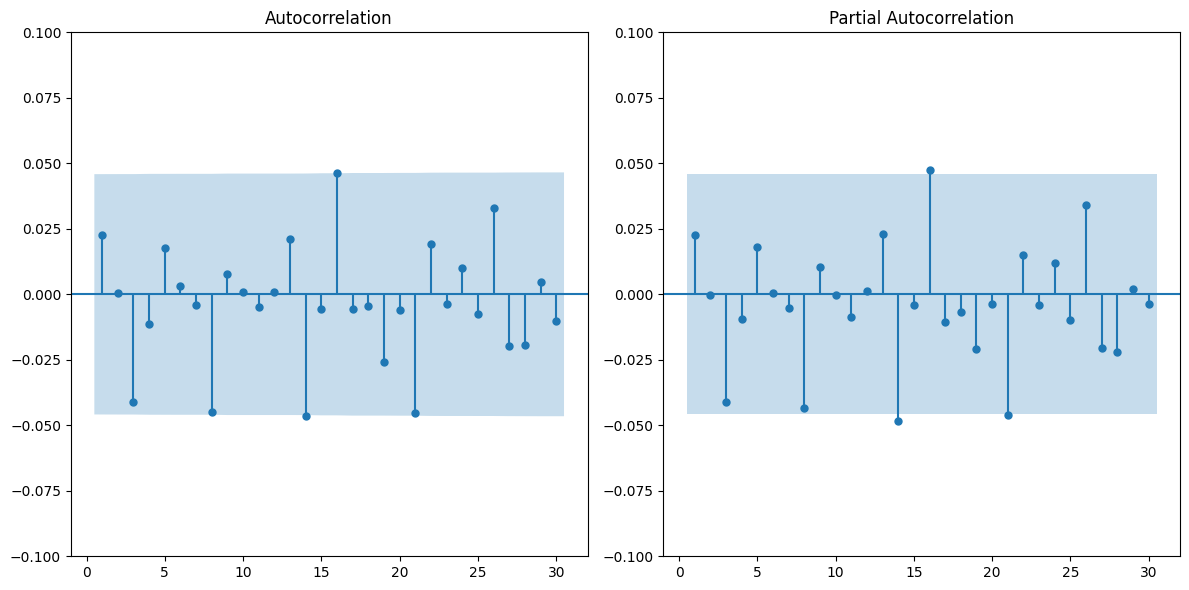

In [58]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

_ = plot_acf(y_diff, ax=ax1, lags=30, zero=False)
_ = plot_pacf(y_diff, ax=ax2, lags=30, zero=False)

ax1.set_ylim(-0.1, 0.1)
ax2.set_ylim(-0.1, 0.1)

plt.tight_layout()
plt.show()


ACF loại bỏ lag0 tất cả đều trong vùng xanh 
=> q = 0  

Tương tự, các giá trị PACF đều nằm trong vùng xanh, tức là không có độ trễ nào nổi bật rõ ràng
=> p = 0

(p, d, q) = (0, 1, 0)

# **ARIMA**

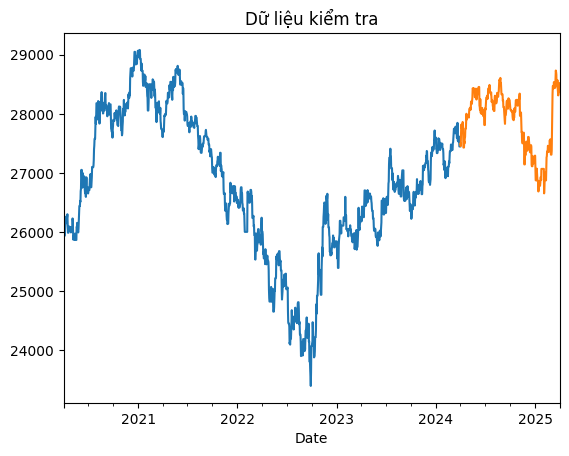

In [59]:
train_size = int(len(y) * 0.8)
train, test = y[:train_size], y[train_size:]

train.plot(title="Dữ liệu huấn luyện")
test.plot(title="Dữ liệu kiểm tra")
plt.show()

In [60]:
# Fit mô hình ARIMA(0, 1, 0) trên tập huấn luyện
model = ARIMA(train, order=(1, 1, 6))
result = model.fit()

print(result.summary())


c:\Users\DELL\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\DELL\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\DELL\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                   Sell   No. Observations:                 1461
Model:                 ARIMA(1, 1, 6)   Log Likelihood               -8884.637
Date:                Sat, 12 Apr 2025   AIC                          17785.274
Time:                        23:15:14   BIC                          17827.563
Sample:                    04-01-2020   HQIC                         17801.049
                         - 03-31-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2035     12.085     -0.017      0.987     -23.890      23.483
ma.L1          0.2053     12.087      0.017      0.986     -23.485      23.896
ma.L2         -0.0133      0.033     -0.409      0.6

# **Đánh giá mô hình**

MAE: 582.3268547593636
MSE: 439648.34649845003
RMSE: 663.0598362881362
MAPE: 2.0744245466578533%


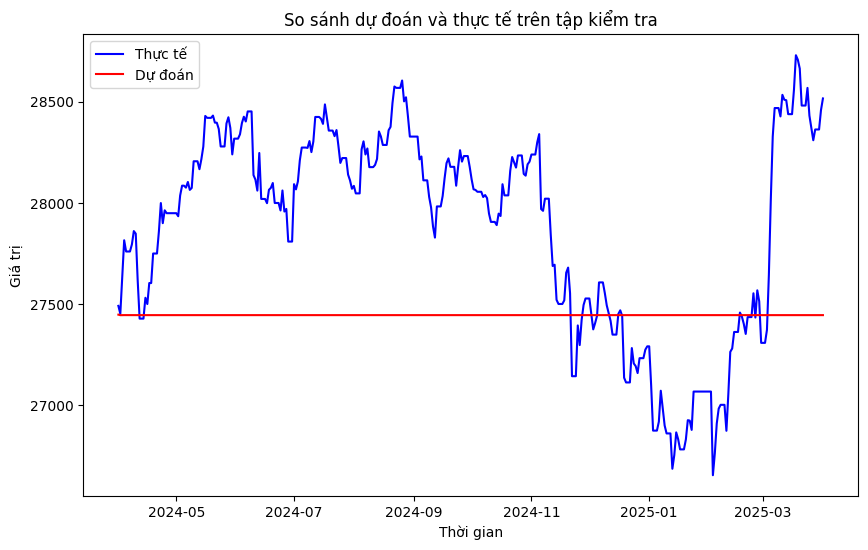

In [61]:
# Dự báo trên tập kiểm tra (test)
y_pred = result.forecast(steps=len(test))

# Đánh giá mô hình
MAE = mean_absolute_error(test, y_pred)
MSE = mean_squared_error(test, y_pred)
RMSE = np.sqrt(MSE)
MAPE = np.mean(np.abs((test - y_pred) / test)) * 100

print(f"MAE: {MAE}")
print(f"MSE: {MSE}")
print(f"RMSE: {RMSE}")
print(f"MAPE: {MAPE}%")

# Vẽ biểu đồ so sánh thực tế và dự báo
plt.figure(figsize=(10, 6))
plt.plot(test, label='Thực tế', color='blue')
plt.plot(y_pred, label='Dự đoán', color='red')
plt.title('So sánh dự đoán và thực tế trên tập kiểm tra')
plt.xlabel('Thời gian')
plt.ylabel('Giá trị')
plt.legend()
plt.show()
